# Intro

 - We can define computer vision as the art of teaching a computer to see.
 - Types of Computer Vision tasks:
  - Binary Classification
  - Multi-class Classification
  - Object Detection
  - Panoptic segmentation

# CV Libraries in PyTorch

- ***torchvision*** contains:
  - Datasets
  - Model architectures
  - Image transformations
- ***torchvision.datasets*** contains:
  - CV datasets
  - series of base classes for making custom datasets
- ***torchvision.models*** contains:
  - CV model architectures
- ***torchvision.transforms*** contains:
  - common image transformations (turning images into numbers, or processing or augmenting images)
---
- ***torch.utils.data.Dataset***: base dataset class for PyTorch
- ***torch.utils.data.Dataloader***: creates a Python iterable over a dataset

These last two classes aren't only for CV tasks, but they can deal with many different data types.

In [1]:
# import dependencies

import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

print(f"torch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


# Getting a dataset

- CV dataset: FashionMNIST contains grayscale images of 10 different kinds of clothing.
- MNIST: Modified National Institute of Standards and Technology
- Multiclass problem
- Our task is to identify the type of clothing in an image.


In [2]:
# Training data
train_data = datasets.FashionMNIST(
    root = "data", # root directory
    download= True, # download data to the root directory
    train= True, # get the training set
    transform= ToTensor(), # transform a PIL image to tensor
    target_transform= None # if you want to transform the labels too
)

test_data = datasets.FashionMNIST(
    root="data",
    download=True,
    train= False,
    transform= ToTensor()
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.4MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 169kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.12MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 12.7MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

### Shapes of input and output

- We have a tensor leading to one lablel.


In [4]:
image.shape

torch.Size([1, 28, 28])

- This corresponds to: [color_channels=1, height=28, width=28]; referred to as CHW
- Sometimes images are represented as HWC instead.
- N stands for number of images in NCHW or NHWC.
- NCHW is the default that PyTorch generally expects.
- However, PyTorch states that NHWC is the best practice for better performance when data is large.

In [5]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [6]:
len(train_data.data), len(train_data.targets)

(60000, 60000)

In [7]:
len(test_data.data), len(test_data.targets)

(10000, 10000)

In [8]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### Data Visualization

In [9]:
import matplotlib.pyplot as plt

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '0')

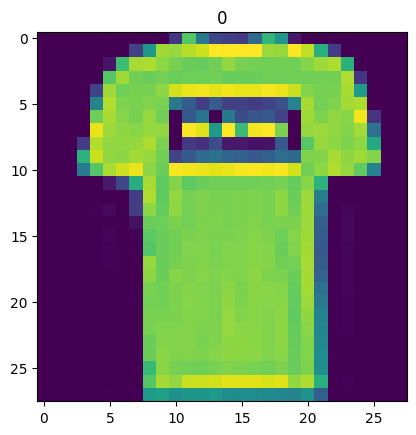

In [10]:
image, label = train_data[1]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label)

Text(0.5, 1.0, 'T-shirt/top')

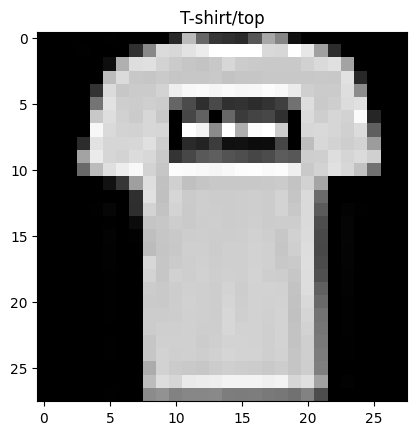

In [11]:
# using the grayscale

plt.imshow(image.squeeze(), cmap="gray")
plt.title(train_data.classes[label])

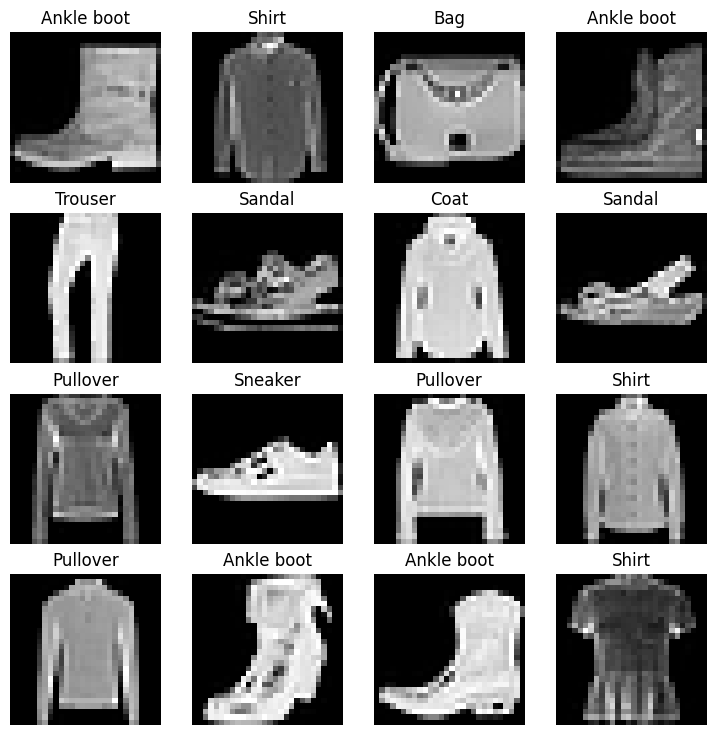

In [12]:
# plotting more images

torch.manual_seed(42)

fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4

for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(train_data.classes[label])
    plt.axis(False);

- Find patterns based on the pixels values.
- 60,000 is considered a small dataset in deep learning.
- Goal: classify each image.

# Create DataLoader

- DataLoader helps load data into a model for training and inference.
- Large dataset are turned into smaller chunks called mini-batches.
- This is computationally more efficient while dealing with large datasets.
- *batch_size* Hyperparameter: You can use it to adjust the mini-batches size. 32 is a good start and powers of 2 are used often.

In [13]:
from torch.utils.data import DataLoader

In [14]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [15]:
print(train_dataloader, test_dataloader)

<torch.utils.data.dataloader.DataLoader object at 0x7c16a1e34450> <torch.utils.data.dataloader.DataLoader object at 0x7c16a1e923d0>


In [16]:
print(len(train_dataloader), BATCH_SIZE)
print(len(test_dataloader), BATCH_SIZE)

1875 32
313 32


In [17]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6


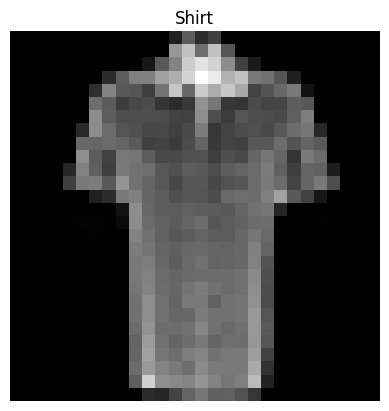

In [18]:
# Check one sample

torch.manual_seed(42)

rand_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(train_data.classes[label])
plt.axis("off");
print(f"Image size: {img.shape}")
print(f"Label: {label}")

# Baseline Model

- Using *nn.Module* to build the baseline model (simplest imagined model).
- Start with the baseline model then add more complications to it subsequently as needed.
- *nn.Flaten()* layer is used to compress the dimensions of image data (tensor) into a single long vector.

In [19]:
# Try nn.Flaten()

x = train_features_batch[0]

output = nn.Flatten()(x)

print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape before flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape before flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [20]:
from torch import nn

In [21]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.layers_stack= nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= input_shape, out_features= hidden_units),
            nn.Linear(in_features= hidden_units, out_features= output_shape)
        )

    def forward(self, x):
        return self.layers_stack(x)

In [22]:
class_names= train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [23]:
# Instantiate a model
torch.manual_seed(42)

model_0= FashionMNISTModelV0(
    input_shape= 784,
    hidden_units= 10,
    output_shape= len(class_names)
)

model_0.to("cpu")

FashionMNISTModelV0(
  (layers_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

### Setup loss, optimizer, and evaluation metrics

- Summon helper functions.

In [24]:
import requests
from pathlib import Path

In [25]:
if Path("helper_functions.py").is_file():
    print("helper_funtions.py already exists.")
else:
    print("Downloading helper_functions.py")
    request= requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py") # raw github url
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

In [26]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 27.8 MB/s eta 0:00:00


In [27]:
import torchmetrics

In [28]:
loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(params= model_0.parameters(), lr= 0.1)
accuracy_fn= torchmetrics.Accuracy(task= "multiclass", num_classes= len(class_names)).to("cpu")

### Measure time of our experiments

- We can compare time of training on CPU vs GPU.

In [29]:
from timeit import default_timer as timer

In [30]:
def print_train_time(start: float, end:float, device: torch.device= None):
    """Prints difference between start and end time.

    Args:
        start (float): start time of computation.
        end (float): end time of computation.
        device ([type], optional): device in which the computation is running on (None is the default).
    """

    total_time= end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time

### Training

- Since we are dealing with batches, there will be nested loops.
- Loss and evaluation metrics will be calculated per batch instead of the whole dataset. So, at the end, we divide the loss and evaluation metric by the number of batches (normalization).

In [31]:
from tqdm.auto import tqdm # Gives progress bar

In [32]:
torch.manual_seed(42)
train_start_time_cpu = timer()

EPOCHS= 3 # small number for faster training

for epoch in range(EPOCHS):

    print(f"Epoch: {epoch}\n-------")

    ### Training ###

    train_loss= 0

    for batch, (X,y) in enumerate(train_dataloader):

        model_0.train()

        train_pred = model_0(X)

        curr_loss = loss_fn(train_pred, y)
        train_loss += curr_loss

        optimizer.zero_grad()

        curr_loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples")

    # Calculate average train loss per batch
    train_loss /= len(train_dataloader)

    ### Testing ###

    test_loss, test_acc = 0, 0  # to accumulate tesing loss and accuracy

    model_0.eval()

    with torch.inference_mode():

        for X,y in test_dataloader:

            test_pred = model_0(X)

            test_loss += loss_fn(test_pred, y)

            test_acc += accuracy_fn(
                preds = test_pred,
                target = y
            )

        # Calculate avergae test loss per batch
        test_loss /= len(test_dataloader)

        # Calculate average accuracy per batch
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:0.5f} | Accuracy: {test_acc:0.5f}")

train_end_time_cpu = timer()

total_train_time_model_0 = print_train_time(
    start = train_start_time_cpu,
    end = train_end_time_cpu,
    device = str(next(model_0.parameters()).device)
)

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954 | Accuracy: 0.82039
Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989 | Accuracy: 0.83197
Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664 | Accuracy: 0.83427

Train time on cpu: 39.086 seconds


### Inference and evaluation

- Create a function that takes:
  1. a trained model
  2. dataloader
  3. loss function
  4. accuracy function
- The function should use the data in the dataloader and the model to make predictions and then evaluate those predictions with the loss and accuracy functions.
- Use the results of this function to compare different models.


In [33]:
import torch

In [34]:
# Turning the code to the device-agnostic mode

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [35]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn: torchmetrics,
               device: torch.device = device):

    """Returns a dictionary contains the model's predictions on the data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on the data_loader
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): A function to calculate the loss for the model's predictions.
        accuracy_fn (torchmetrics): A function to calculate accuracy between the model's predictions and the true labels.
        device (str, optional): Target device to compute on. Default is device.

    Returns:
        (dict): The resulting predictions of the model on the dataloader.
    """

    loss, acc = 0, 0

    model.eval()

    model.to(device)
    loss_fn.to(device)
    accuracy_fn.to(device)

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss += loss_fn(preds, y)
            acc += accuracy_fn(
                preds = preds,
                target = y
            )

        # Average loss and accuracy per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_accuracy": acc.item()
    }

In [36]:
# Evaluate model_0

model_0_eval_results = eval_model(
    model = model_0,
    data_loader = test_dataloader,
    loss_fn = loss_fn,
    accuracy_fn = accuracy_fn
)

model_0_eval_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_accuracy': 0.8342651724815369}

# Non-linear Model

- Does our data need non-linearity?
  - Linear = straight
  - Non-linear = non-straight

In [37]:
class FashionMNISTModelV1(nn.Module):

    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.layers_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x:torch.Tensor):
        return self.layers_stack(x)

- In ML, it is a good practice to start with a baseline model then experiment changing one thing after another.
- This time, we added non-linear functions.

In [38]:
# Instantiate model_1

torch.manual_seed(42)

model_1 = FashionMNISTModelV1(
    input_shape = 784,
    hidden_units = 10,
    output_shape = len(class_names)
).to(device)

next(model_1.parameters()).device

device(type='cuda', index=0)

### Setup loss, optimizer, and evaluation metrics

In [39]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params = model_1.parameters(),
    lr = 0.1
)

accuracy_fn = torchmetrics.Accuracy(
    task = "multiclass",
    num_classes = len(class_names)
).to(device)

### Wrapping up training and testing loops

- Create functions that can be repeatedly called:
  - train_step() will take:
    - model
    - DataLoader
    - loss function
    - optimizer
  - test_step() will take:
    - model
    - DataLoader
    - loss function
    - evaluation function

In [40]:
def train_step(model: torch.nn.Module,
          data_loader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          accuracy_fn: torchmetrics.Metric,
          device: torch.device = device):
      """Loop through train data to train your model"""

      train_loss, train_acc = 0,0
      model.to(device)

      for batch, (X,y) in enumerate(data_loader):

          X, y = X.to(device), y.to(device)

          train_preds = model(X)

          curr_loss = loss_fn(train_preds, y)
          train_loss += curr_loss
          train_acc += accuracy_fn(preds = train_preds,
                                   target = y)

          optimizer.zero_grad()

          curr_loss.backward()

          optimizer.step()

      # Average loss and accuracy

      train_loss /= len(data_loader)
      train_acc /= len(data_loader)

      print(f"Train Loss: {train_loss:.5f} | Train accuracy:  {train_acc:.2f}%")

In [41]:
def test_step(model: torch.nn.Module,
         data_loader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         accuracy_fn: torchmetrics.Metric,
         device: torch.device = device):
      """Testing loop"""

      test_loss, test_acc = 0, 0
      model.to(device)
      model.eval()

      with torch.inference_mode():

          for X, y in data_loader:

              X, y = X.to(device), y.to(device)

              test_preds = model(X)

              test_loss += loss_fn(test_preds, y)

              test_acc += accuracy_fn(preds = test_preds,
                                      target = y)

          # Average loss and accuracy per batch
          test_loss /= len(data_loader)
          test_acc /= len(data_loader)

          print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

- Create a loop for a number of epochs.
- Run these functions inside the loop.
- Some people customize how often they do the testing step.

In [42]:
from timeit import default_timer as timer

In [43]:
torch.manual_seed(42)

train_start_time_gpu = timer()

EPOCHS = 3

for epoch in tqdm(range(EPOCHS)):

    print(f"Epoch: {epoch}\n-------------")

    train_step(
        model = model_1,
        data_loader = train_dataloader,
        loss_fn = loss_fn,
        optimizer = optimizer,
        accuracy_fn = accuracy_fn
    )

    test_step(
        model = model_1,
        data_loader = test_dataloader,
        loss_fn = loss_fn,
        accuracy_fn = accuracy_fn
    )

train_end_time_gpu = timer()

total_train_time_model_1 = print_train_time(start = train_start_time_gpu,
                                            end = train_end_time_gpu,
                                            device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------------
Train Loss: 1.09199 | Train accuracy:  0.61%
Test Loss: 0.95636 | Test Accuracy: 0.65%
Epoch: 1
-------------
Train Loss: 0.78101 | Train accuracy:  0.72%
Test Loss: 0.72227 | Test Accuracy: 0.74%
Epoch: 2
-------------
Train Loss: 0.67027 | Train accuracy:  0.76%
Test Loss: 0.68500 | Test Accuracy: 0.75%

Train time on cuda: 37.494 seconds


- The traininig time depends on the quality of the used hardware.
- There is a time spent in transfering data from CPU to GPU.
- So, GPU works best for large dataset because for smaller dataset this transfering time outwiegh its computing power benefit.


In [44]:
# Evaluate the model

torch.manual_seed(42)

model_1_eval_results = eval_model(model = model_1,
                            data_loader = test_dataloader,
                            loss_fn = loss_fn,
                            accuracy_fn = accuracy_fn)
model_1_eval_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_accuracy': 0.7501996755599976}

In [45]:
model_0_eval_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_accuracy': 0.8342651724815369}

# CNN Model

- CNN is used to find patterns in visual data.
- We will try the [TinyVGG](https://poloclub.github.io/cnn-explainer/).
- The structure:
  - Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> output layer
  - We can upscale and repeat: [Convolutional layer -> activation layer -> pooling layer]
- Choosing a model depends on the data and the problem type:
  - Structured (tabular) data: XGBoost, Random Forests
  - Unstructured data: CNNs, Transformers

In [46]:
class FashionMNISTModelV2(nn.Module):
    """
      Model architecture copying TinyVGG from: https://poloclub.github.io/cnn-explainer/
    """

    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()

        # block1 contains: two convolution layers and one max pooling layer
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape, # Number of channels in the input image
                      out_channels = hidden_units, # Number of channels produced by the convolution
                      kernel_size = 3, # Convolution filter size
                      stride = 1, # Step size that the convolution kernel takes at a time
                      padding = 1), # Add padding to all four sides of the input
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      stride = 1,
                      kernel_size = 3,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,
                         stride = 2) # default stride takes the same values as kernel_size
        )

        # block2 is a duplicate of block1
        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units*7*7,
                      out_features = output_shape)
        )

    def forward(self, x:torch.Tensor):
        x = self.block1(x)
        x = self.block2(x)
        return self.classifier(x)

In [47]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape = 1,
                              hidden_units = 10,
                              output_shape = len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

- 2d in nn.Conv2d() refers to two diminsional data: height X width
- There is alson nn.Conv1d() for 1D data such as text, and nn.Conv3d() for 3D objects.
- We will test the model layers on a toy data.

In [48]:
torch.manual_seed(42)

# Mimic the image batch by creating sample batch of random numbers with the same size
img_mimic = torch.randn(size=(32, 3, 64, 64)) # [batch_sizse, color_channels, height, width]
test_img = img_mimic[0]

print(f"Image batch shape: {img_mimic.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_img.shape} -> [color_channels, height, width]")
print(f"Pixel values of a single image:\n{test_img}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Pixel values of a single image:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.

### Convolution Layer: Dig Deeper

In [49]:
# Create a convolution layer with the same dimensions as TinyVGG

torch.manual_seed(42)

# 1
conv_layer = nn.Conv2d(in_channels = 3,
                       out_channels = 10,
                       kernel_size = 3,
                       stride = 1,
                       padding = 0)

In [50]:
conv_layer(test_img).shape

torch.Size([10, 62, 62])

In [51]:
torch.manual_seed(42)

# 2
conv_layer_2 = nn.Conv2d(in_channels = 3,
                         out_channels = 10,
                         kernel_size = (3,9),
                         stride = 3,
                         padding = 0)

In [52]:
conv_layer_2(test_img.unsqueeze(dim=0)).shape

torch.Size([1, 10, 21, 19])

- The role of the convolution layer is to compress the information stored in the input image throuh the layer's internal parameters.
- During the training of the network, the layer's internal parameters are updated to lower the loss function.
- The layer's may calculate their parameter updates differently.

In [53]:
conv_layer.state_dict()

OrderedDict([('weight',
              tensor([[[[ 0.1471,  0.1597, -0.0451],
                        [ 0.1768, -0.0422,  0.0388],
                        [-0.0937,  0.1130,  0.1697]],
              
                       [[-0.1412,  0.1673,  0.0360],
                        [ 0.1422,  0.0261,  0.0928],
                        [-0.0272,  0.1484,  0.0284]],
              
                       [[-0.0898,  0.0491, -0.0887],
                        [-0.0226, -0.0782,  0.1277],
                        [-0.1519, -0.0887, -0.0543]]],
              
              
                      [[[-0.1157,  0.0182, -0.1901],
                        [ 0.1738, -0.1635,  0.1486],
                        [ 0.0320, -0.0625,  0.1189]],
              
                       [[ 0.0300,  0.1555,  0.0210],
                        [-0.0607,  0.0517, -0.0522],
                        [ 0.0810,  0.1718,  0.1112]],
              
                       [[-0.0841,  0.1111,  0.0344],
                        [ 0.0977

In [54]:
conv_layer_2.state_dict().keys()

odict_keys(['weight', 'bias'])

In [55]:
print(f"conv_layer weight's shape:\n{conv_layer.weight.shape} [out_channels, in_channels, kernel_size, kernel_size]")
print(f"conv_layer bias's shape:\n{conv_layer.bias.shape} [out_channels]")

conv_layer weight's shape:
torch.Size([10, 3, 3, 3]) [out_channels, in_channels, kernel_size, kernel_size]
conv_layer bias's shape:
torch.Size([10]) [out_channels]


### MaxPool Layer: Dig Deeper

- What does happen when you move data through MaxPool2d?

In [56]:
print(f'Test image original shape: {test_img.shape}')
print(f'Test image with unsqueezed dimension: {test_img.unsqueeze(dim=0).shape}')

# Sample MaxPool layer
maxpool_layer = nn.MaxPool2d(kernel_size=3)

# Passing to conv layer
test_img_conv = conv_layer(test_img.unsqueeze(dim=0))
print(f'Shape after passing through conv_layer: {test_img_conv.shape}')

# Passing to the MaxPool
test_img_conv_maxpool = maxpool_layer(test_img_conv)
print(f'Shape after passing through conv_layer and MaxPool layer: {test_img_conv_maxpool.shape}')

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after passing through conv_layer: torch.Size([1, 10, 62, 62])
Shape after passing through conv_layer and MaxPool layer: torch.Size([1, 10, 20, 20])


- Try MaxPool with a smaller tensor.

In [57]:
torch.manual_seed(42)

# Random tensor: same number of dimensions, but different dimension values
rand_tensor = torch.randn(size=(1, 1, 2, 2))
print(f'Random tensor:\n{rand_tensor}')
print(f'Random tensor shape: {rand_tensor.shape}')

maxpool_layer = nn.MaxPool2d(kernel_size=2)

# Passing the random tensor to the maxpool layer
maxpooled_tensor = maxpool_layer(rand_tensor)
print(f"\nMaxPooled tensor:\n{maxpooled_tensor} <- Notice that this is the maximum value in the original random tensor")
print(f"MaxPooled tensor shape: {maxpooled_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

MaxPooled tensor:
tensor([[[[0.3367]]]]) <- Notice that this is the maximum value in the original random tensor
MaxPooled tensor shape: torch.Size([1, 1, 1, 1])


- Neural Networks Layers are technically compressing the data to a lower dimension.
  - Find patterns in a set of numbers
  - Represent thos patterns in a smaller set of numbers
  - The new representation is still predictive because it retains a segnificant amount of the information
- It can be said that Neural Networks interpret intilligence as compression.

In [58]:
# Using the AvgPool layer
torch.manual_seed(42)

t = torch.tensor(
    [[[[1,2,3,4,5,6,7,8],
       [1,2,3,4,5,6,7,8],
       [1,2,3,4,5,6,7,8],
       [1,2,3,4,5,6,7,8],
       [1,2,3,4,5,6,7,8],
       [1,2,3,4,5,6,7,8],
       [1,2,3,4,5,6,7,8],
       [1,2,3,4,5,6,7,8],]]],
    dtype = torch.float
)
print(f'Our tensor {t.shape}')

# rand_tensor = torch.randn(size=(1,1,8,8))
# print(f'Our tensor:\n{rand_tensor}')
# print(f'Our tensor {rand_tensor.shape}')

avgpool_layer = nn.AvgPool2d(kernel_size=4)

# Passing the random tensor through the avgpool layer
avgpooled_tensor = avgpool_layer(t)
print(f'\nAvgPooled tensor:\n{avgpooled_tensor} <- we have the average value instead of the maximum value')
print(f'AvgPooled tensor shape: {avgpooled_tensor.shape}')

Our tensor torch.Size([1, 1, 8, 8])

AvgPooled tensor:
tensor([[[[2.5000, 6.5000],
          [2.5000, 6.5000]]]]) <- we have the average value instead of the maximum value
AvgPooled tensor shape: torch.Size([1, 1, 2, 2])


### Setting Up Loss function and Optimizer

- For model_2

In [59]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    model_2.parameters(),
    lr = 0.1
)

### Training and Testing model_2

- Using our previously created functions
- Measure time to compare with other models

In [60]:
from timeit import default_timer as timer

In [61]:
torch.manual_seed(42)

start_time_model_2 = timer()

# Train and test loop
EPOCHS = 3

for epoch in tqdm(range(EPOCHS)):
    print(f"-----Epoch: {epoch}\n-----")

    ### Train ###
    train_step(
        data_loader = train_dataloader,
        model = model_2,
        loss_fn = loss_fn,
        optimizer = optimizer,
        accuracy_fn = accuracy_fn,
        device = device
    )

    ### Test ###
    test_step(
        data_loader = test_dataloader,
        model = model_2,
        loss_fn = loss_fn,
        accuracy_fn = accuracy_fn,
        device = device
    )

end_time_model_2 = timer()
total_train_time_model_2 = print_train_time(
    start = start_time_model_2,
    end = end_time_model_2,
    device = device
)

  0%|          | 0/3 [00:00<?, ?it/s]

-----Epoch: 0
-----
Train Loss: 0.59574 | Train accuracy:  0.78%
Test Loss: 0.39182 | Test Accuracy: 0.86%
-----Epoch: 1
-----
Train Loss: 0.36237 | Train accuracy:  0.87%
Test Loss: 0.36998 | Test Accuracy: 0.86%
-----Epoch: 2
-----
Train Loss: 0.32644 | Train accuracy:  0.88%
Test Loss: 0.32245 | Test Accuracy: 0.88%

Train time on cuda: 45.532 seconds


In [62]:
# Evaluate model_2 with test data
model_2_eval_results = eval_model(
    model = model_2,
    data_loader = test_dataloader,
    loss_fn = loss_fn,
    accuracy_fn = accuracy_fn
)
model_2_eval_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32244694232940674,
 'model_accuracy': 0.8820886611938477}

# Model Comparisons

- We now have 3 different models.
  - Baseline Model: model_0
  - Non-linear Model: model_1
  - CNN Model: model_2

In [63]:
import pandas as pd

In [64]:
# Putting these models' results in a dataframe
models_eval_results = pd.DataFrame(
    [
        model_0_eval_results,
        model_1_eval_results,
        model_2_eval_results
    ],
    [
        total_train_time_model_0,
        total_train_time_model_1,
        total_train_time_model_2
    ]
)
models_eval_results

,model_name,model_loss,model_accuracy
39.085689,FashionMNISTModelV0,0.476639,0.834265
37.493968,FashionMNISTModelV1,0.685001,0.750200
45.531819,FashionMNISTModelV2,0.322447,0.882089


- Larger and more complex models perform better but at the cost of longer training time (slower speed performance).
- This also relies on the hardware.

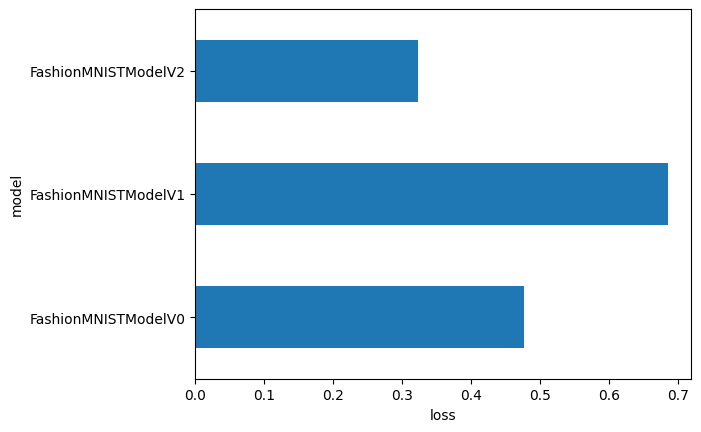

In [65]:
# Visualization of the results
models_eval_results.set_index("model_name")["model_loss"].plot(kind="barh")
plt.xlabel("loss")
plt.ylabel("model");

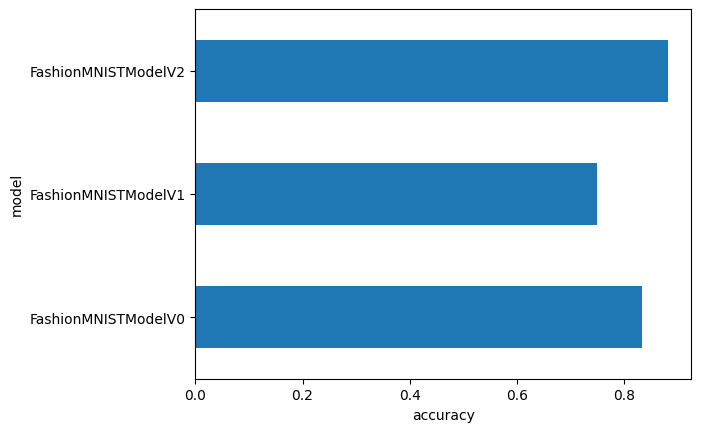

In [66]:
# Visualization of the results
models_eval_results.set_index("model_name")["model_accuracy"].plot(kind="barh")
plt.xlabel("accuracy")
plt.ylabel("model");

# Choosing the best model

- Best model: model_2
- It is a good idea to create a function to make predictions taking some data.

In [67]:
def make_predictions(model: nn.Module,
                     data: list,
                     device: torch.device = device):

    pred_probs = []

    model.eval()
    with torch.inference_mode():
        for sample in data:
            # sample preparation
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # forward pass: outputs raw logits
            pred_logits = model(sample)

            # Get prediction probability
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu()) # It is better to get pred_prob off GPU for further calculations

    return torch.stack(pred_probs) # torch.stack: turns list into tensor

In [68]:
import random

In [69]:
random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=18): # k: number of samples
    test_samples.append(sample)
    test_labels.append(label)

print(f"Image shape of the test sample: {test_samples[0].shape}")
print(f"Test sample label: {test_labels[0]} {class_names[test_labels[0]]}")

Image shape of the test sample: torch.Size([1, 28, 28])
Test sample label: 5 Sandal


In [70]:
# Making predictions

pred_probs = make_predictions(model = model_2,
                              data = test_samples)
print(pred_probs[:4])

pred_classes = pred_probs.argmax(dim=1)
print("\n"+str(pred_classes))

tensor([[3.2993e-07, 4.6200e-08, 8.7451e-08, 8.9164e-08, 1.5485e-08, 9.9970e-01,
         1.3332e-06, 1.5491e-05, 2.5021e-05, 2.5895e-04],
        [3.7268e-02, 5.1035e-01, 2.1151e-03, 1.5684e-01, 3.1393e-02, 5.6379e-04,
         2.5982e-01, 3.8616e-04, 5.7554e-04, 6.9194e-04],
        [1.8429e-05, 1.0222e-06, 3.3897e-05, 3.6785e-06, 6.5542e-06, 4.4578e-04,
         6.1727e-06, 6.7505e-01, 1.6987e-03, 3.2274e-01],
        [1.3572e-03, 2.0316e-04, 1.1928e-01, 1.9745e-03, 8.7454e-01, 9.3514e-06,
         1.8956e-03, 1.1332e-05, 7.0362e-04, 2.3317e-05]])

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1, 9, 7, 2, 0, 1, 0, 3, 5, 4])


In [71]:
# compare test labels to predictions' labels
# pred_classes, test_labels

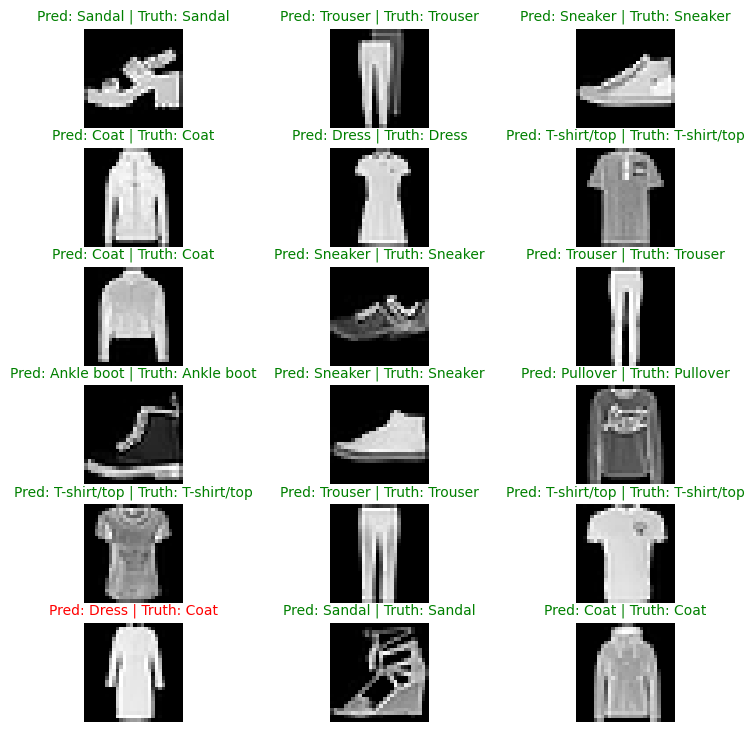

In [72]:
# Plot predictions
plt.figure(figsize=(9,9))

for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(6, 3, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Get the predicted label
    pred_label = class_names[pred_classes[i]]

    # Get the truth label
    truth_label = class_names[test_labels[i]]

    # Put proper title
    title = f"Pred: {pred_label} | Truth: {truth_label}"

    # Make green color for a correct prediction and red color for wrong one
    if pred_label == truth_label:
        plt.title(title, fontsize=10, c="g")
    else:
        plt.title(title, fontsize=10, c="r")

    plt.axis(False);

# Evalutation With A Confusion Matrix

- Visual Metric
- Shows the model's confusion between predictions and true labels.

In [73]:
from tqdm.auto import tqdm # Processing bar

In [74]:
# model_2 predictions

y_preds = []
model_2.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making Predictions"):
        X, y = X.to(device), y.to(device)
        y_logits = model_2(X)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making Predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [75]:
# Install functions needed for instantiating and visualizing the confusion matrix

try:
    # Check if the right version exists
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split('.')[1]) >= 19 # This version is necessary
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.3


### Plot the confusion matrix

In [76]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [77]:
cmatrix = ConfusionMatrix(num_classes = len(class_names), task = "multiclass") # Instance of the confusion matrix
cmatrix_tensor = cmatrix(preds = y_pred_tensor,
                         target = test_data.targets)

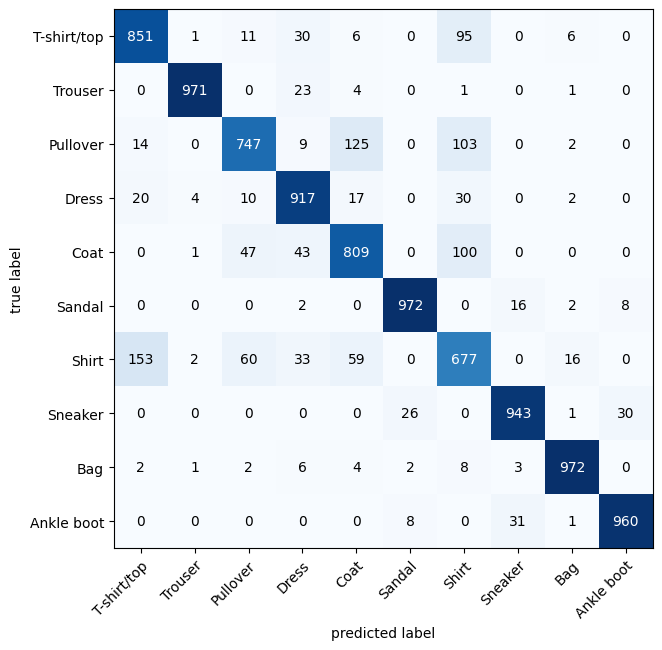

In [78]:
fig, ax = plot_confusion_matrix(
    conf_mat = cmatrix_tensor.numpy(),
    class_names = class_names,
    figsize = (10, 7)
);

- Ideal model has values in the diagonal squares and zero everywhere else.
- Our model performs pretty well.
- It is clear that the problematic images are the ones with similar attributes like "T-shirt/top" and "Shirt".
- In this way, we can detect the misbehave of the model and fix it better than using only one single metric.
-


If you found something wrong, please contact me at: muhammadhelmymmo@gmail.com